# QUESTION 1

Below is some helper code shared between the 2 functions


In [626]:
from typing import List
from math import sin, cos, tan, radians, pi, sqrt, degrees

import matplotlib.pyplot as plot
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

In [627]:
def plot_path_x_y_angular_velocities(path_x, path_y, angular_momentum) -> None:

    # Graph the path of the robot
    figure, axes = plot.subplots()
    
    # figure.set_size_inches(9, 9)
    axes.set_title("Path")
    axes.set_xlim((-3, 3))
    axes.set_ylim((-3, 3))
    axes.add_patch(Circle((0, 0), 2.5, facecolor="none", ec='k', lw=2))
    for index, path in enumerate(path_x):
        axes.plot(path_x[index], path_y[index], lw=4)

    # Flatten lists
    path_x = [item for sublist in path_x for item in sublist]
    path_y = [item for sublist in path_y for item in sublist]
    angular_momentum = [item for sublist in angular_momentum for item in sublist]

    # Plot angular momentum by command (each command has constant angular momentum)
    figure, axes = plot.subplots()
    figure.set_size_inches(9, 9)
    axes.plot(angular_momentum)
    axes.set_title("Angular Momentum")
    axes.set_xlabel("Time step")

    # Plot x position by time
    figure, axes = plot.subplots()
    figure.set_size_inches(9, 9)
    axes.plot(path_x, label="x")
    axes.set_xlabel("Time step")
    axes.set_title("Position X")

    # Plot y position by time
    figure, axes = plot.subplots()
    figure.set_size_inches(9, 9)
    axes.plot(path_y, label="y")
    axes.set_xlabel("Time step")
    axes.set_title("Position Y")

# Section A: Skid Steer Circle

In [628]:

class SkidRobot:
    def __init__(self, length, width, x=0, y=0) -> None:
        """Creates a robot

        Args:
            length (_type_): Uses Meters
            width (_type_): Uses Meters
        """
        self.length = length
        self.width = width
        self.x = x
        self.y = y
        self.theta = 0
    
    def move(self, velocity_left, velocity_right, dt=0.1) -> None:
        self.x -= (.5 * (velocity_left + velocity_right)) * sin(self.theta) * dt
        self.y += (.5 * (velocity_left + velocity_right)) * cos(self.theta) * dt
        self.theta += (1 / self.width) * (velocity_right - velocity_left) * dt
        
    def get_coords(self) -> "tuple[float, float]":
        return (self.x, self.y)
    
    def move_for_duration(self, duration, velocity_left, velocity_right, dt = 0.1) -> "tuple[list, list, list]":
        path_x = []
        path_y = []
        angular_momentum = []
        
        # put loop in terms of dt = 0.1
        current_time = 0
        while (current_time < duration):
            path_x.append(self.x)
            path_y.append(self.y)
            angular_momentum.append(self.get_angular_momentum(dt, velocity_left, velocity_right))
            self.move(velocity_left, velocity_right, dt)
            current_time += dt

        # Store final point
        path_x.append(self.x)
        path_y.append(self.y)
        return path_x, path_y, angular_momentum

    def get_bounds(self) -> "tuple[float, float]":
        return (self.width, self.length)

    def get_angular_momentum(self, duration, velocity_left, velocity_right) -> float:
        delta_theta = duration * ((velocity_right - velocity_left) / self.width)
        return radians(delta_theta)
    
    def calculate_error_move(self, vl, vr, dt=0.1):
        r = self.get_r(vl, vr)
        
        circumference = 2 * r * pi
        
        # Perform Move
        self.move(vl, vr, dt)
        
        # calculate theoretical position
        t_x, t_y = (r * sin(radians(self.theta)), r * -cos(radians(self.theta)))
        t_theta = (sqrt(t_x ** 2 + t_y ** 2) / circumference) * 360
        
        # Percent error calculation
        p_x = abs(1 - (abs(self.x - t_x) / abs(t_x))) * 100
        p_y = abs(1 - (abs(self.y - t_y) / abs(t_y))) * 100
        p_theta = abs(1 - (abs(self.theta - t_theta) / abs(t_theta))) * 100
        
        return [(p_x, p_y, p_theta), (t_x, t_y, t_theta), (self.x, self.y, degrees(self.theta))]

    def get_R(self, vr, vl):
        return (self.width / 2) * ((vr + vl) / (vr - vl))

In [629]:
robot = SkidRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []


# Move 2.4m up, .3 seconds at 8 m/s 

# turn for 4 seconds at 6.1875 +- m/s

# 19 time steps

# Move to outside of the circle
duration, velocity_left, velocity_right = .3, 8, 8
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(duration, velocity_left, velocity_right)

path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

# Turn in place 90
duration, velocity_left, velocity_right = 1, 0.43197, -.43197

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(duration, velocity_left, velocity_right)


print(robot.theta)

path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

duration, velocity_left, velocity_right = 1.9, 8.92, 7.08
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(duration, velocity_left, velocity_right, 0.1)


path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)



-1.7278800000000003


## Plot the resulting path

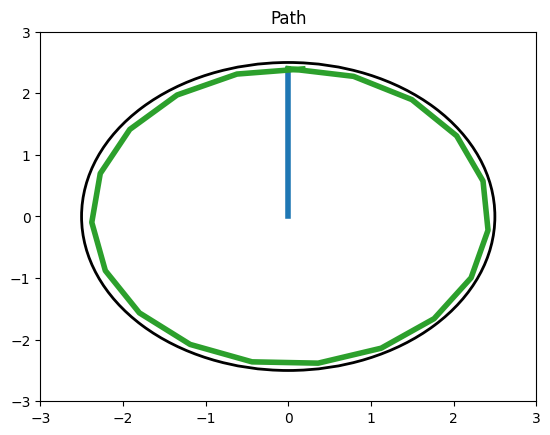

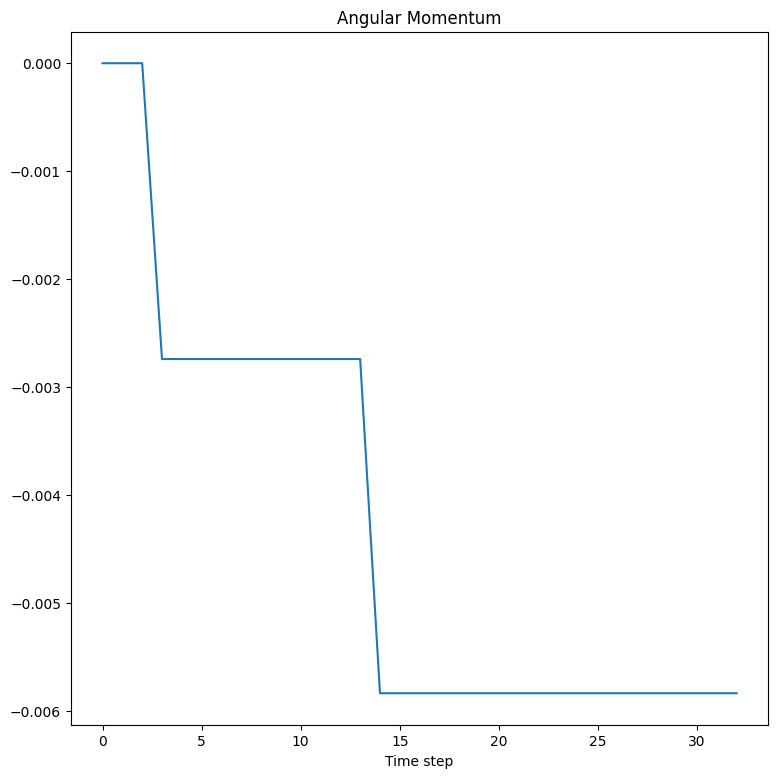

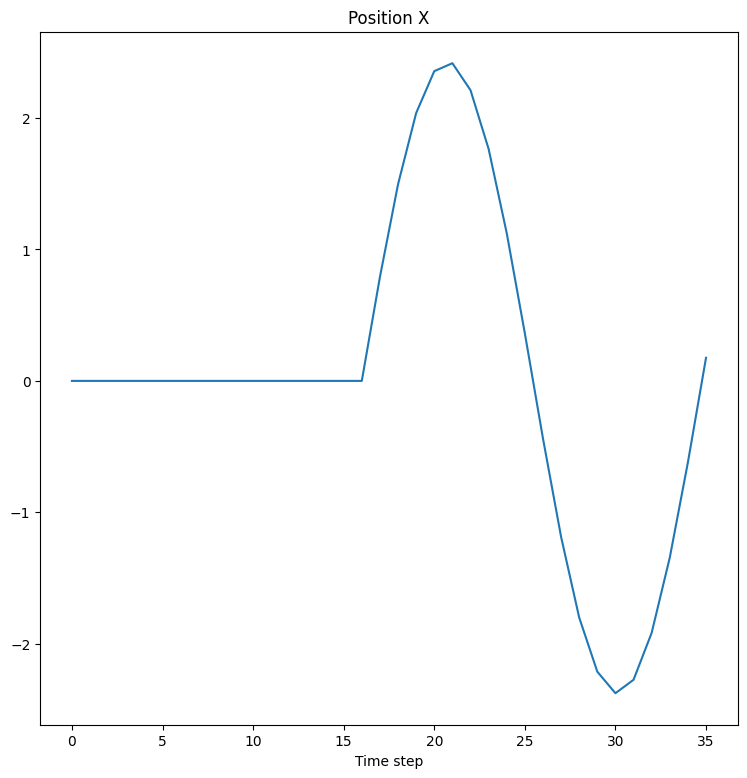

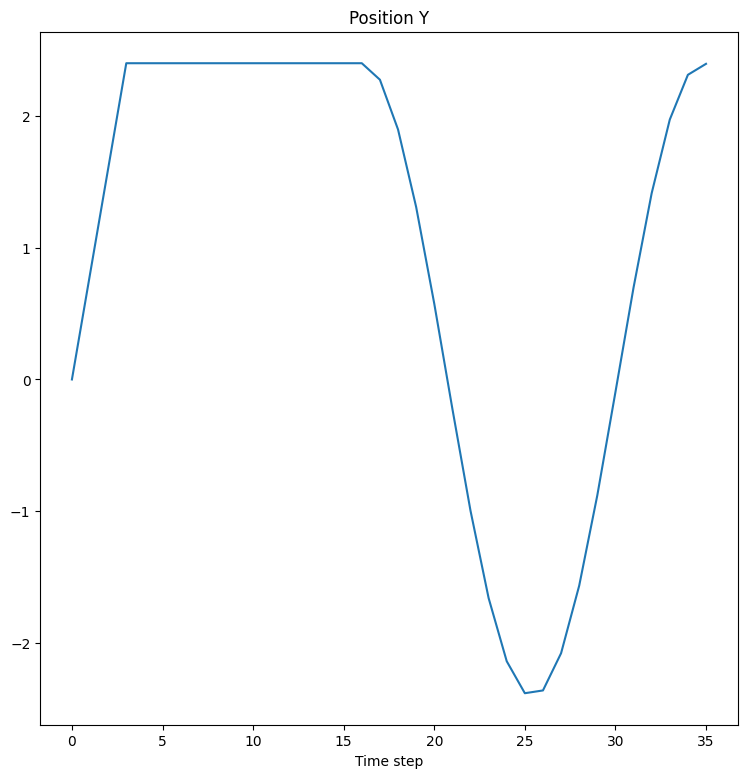

In [630]:
plot_path_x_y_angular_velocities(path_x, path_y, angular_momentum)

## Section B: Ackerman Steering

In [631]:
class AckermanRobot:
    def __init__(self, length, width, x=0, y=0) -> None:
        """Creates a robot

        Args:
            length (_type_): Uses Meters
            width (_type_): Uses Meters
        """
        self.length = length
        self.width = width
        self.x = x
        self.y = y
        self.theta = 0

    def move(self, velocity: int, theta_w: int, dt=0.1) -> None:
        # Angle change for vehicle:
        simulation_timestep = 0.0001
        for i in range(int(dt / simulation_timestep)):
            if theta_w:
                self.theta += (velocity / self.get_R(velocity, theta_w)) * simulation_timestep
                
            # Drive 🚓
            self.x -= velocity * sin(self.theta) * simulation_timestep
            self.y += velocity * cos(self.theta) * simulation_timestep
        


    def get_coords(self) -> "tuple[float, float]":
        return (self.x, self.y)

    def move_for_duration(
        self, duration, velocity, theta, dt=0.1
    ) -> "tuple[list, list, list]":
        path_x = []
        path_y = []
        angular_momentum = []

        # put loop in terms of dt = 0.1
        current_time = 0
        while current_time < duration:
            path_x.append(self.x)
            path_y.append(self.y)
            angular_momentum.append(
                self.get_angular_momentum(dt, velocity, theta)
            )
            self.move(velocity, theta, dt)
            print(self.theta)
            current_time += dt

        # Store final point
        path_x.append(self.x)
        path_y.append(self.y)
        return path_x, path_y, angular_momentum

    def get_bounds(self) -> "tuple[float, float]":
        return (self.width, self.length)

    def get_angular_momentum(self, duration, velocity, theta_w) -> float:
        delta_theta = duration * (velocity / self.width)
        return delta_theta

    def calculate_error_move(self, vl, vr, dt=0.1):
        r = self.get_r(vl, vr)

        circumference = 2 * r * pi

        # Perform Move
        self.move(vl, vr, dt)

        # calculate theoretical position
        t_x, t_y = (r * sin(self.theta), r * -cos(self.theta))
        t_theta = (sqrt(t_x**2 + t_y**2) / circumference) * 360

        # Percent error calculation
        p_x = abs(1 - (abs(self.x - t_x) / abs(t_x))) * 100
        p_y = abs(1 - (abs(self.y - t_y) / abs(t_y))) * 100
        p_theta = abs(1 - (abs(self.theta - t_theta) / abs(t_theta))) * 100

        return [
            (p_x, p_y, p_theta),
            (t_x, t_y, t_theta),
            (self.x, self.y, self.theta),
        ]

    def get_R(self, v, theta):      
        return self.length / tan(theta)


0.7842763893475336
1.5685527786950606
2.352829168042687
3.137105557390436
(-2.0400885373647024, 0.0037770444409695914): 179.74290832550764
3.501274012273621
3.8654424671568055
4.22961092203999
4.593779376923175
(-0.10287549421142812, -2.187078630783805): 263.20417031193494
4.95794783180636
5.322116286689544
5.686284741572729
6.050453196455914
2.294328898541697 -0.5119505569957377 6.050453196455914
(2.294328898541697, -0.5119505569957377): 346.6654322983622


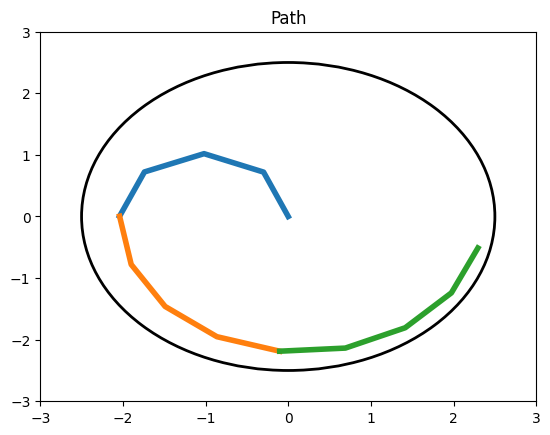

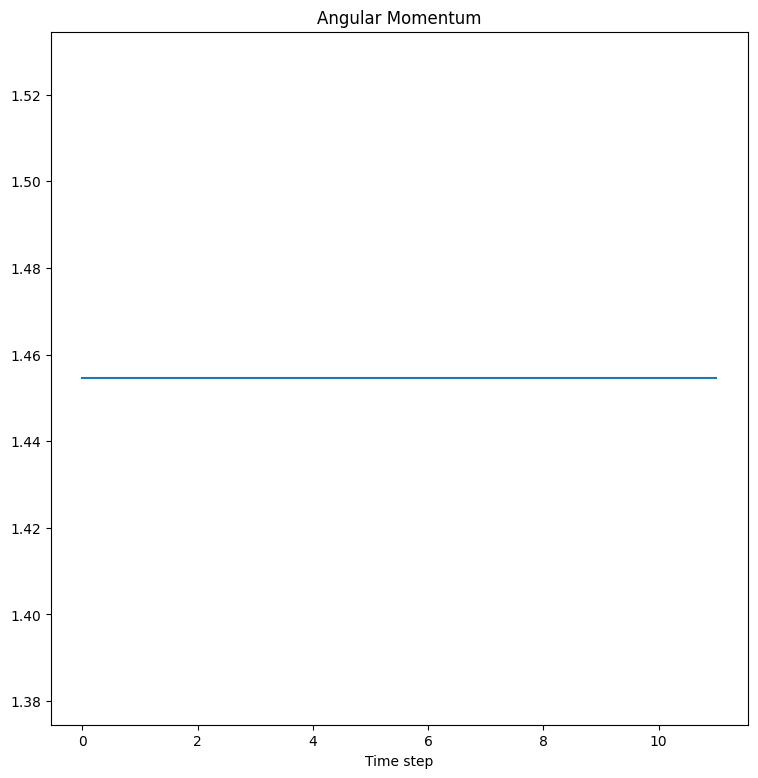

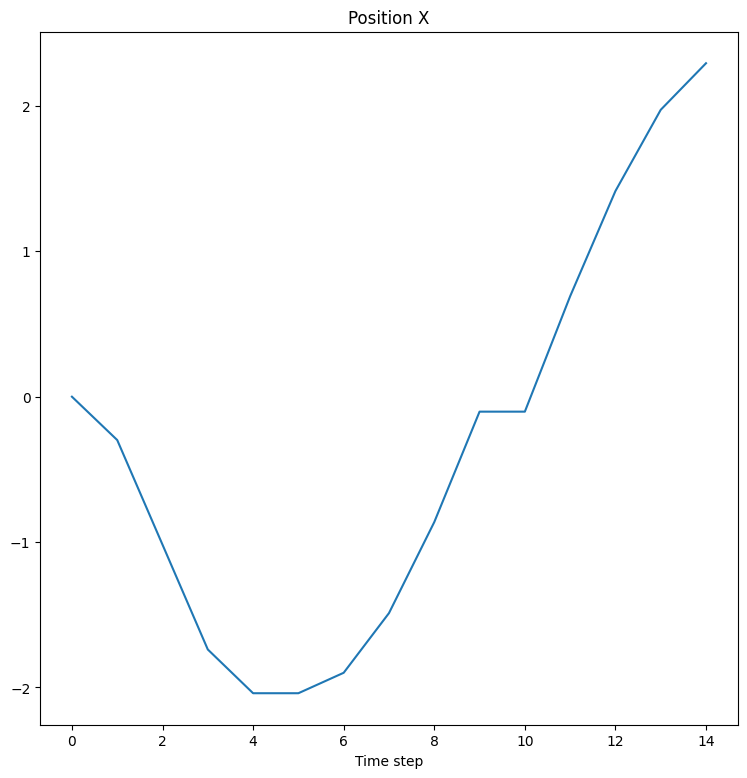

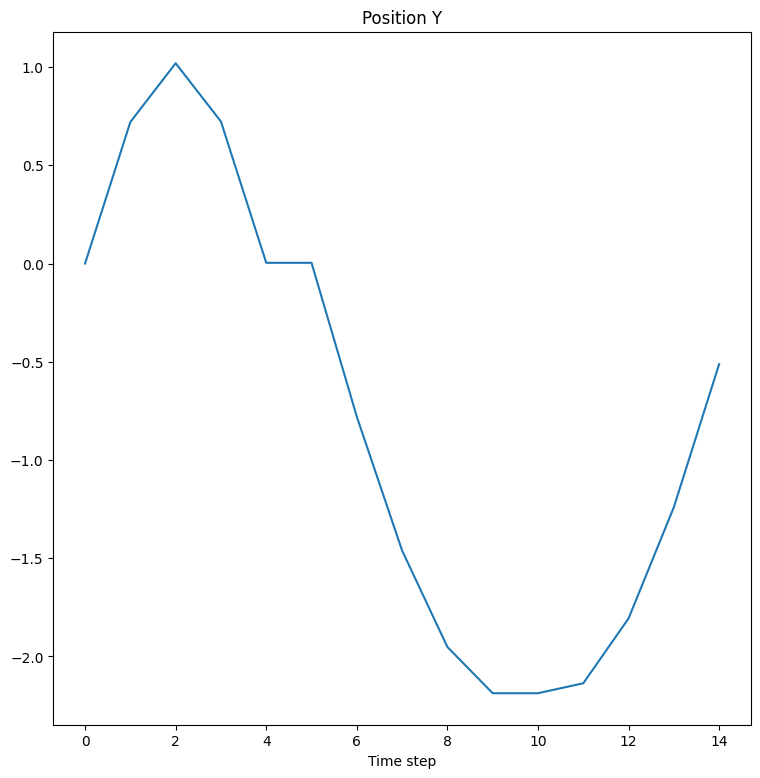

In [632]:
robot = AckermanRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []


#First angle 0.634022719663 @ 0.4 sec

#Straight 0.1 sec

#Second angle 0.329771529972 @ ? sec

# Move to outside of the circle
# robot.theta = 0.634022719663
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.4, 8, 0.634, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.4, 8, 0.329, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")
angular_momentum.append(sub_angular_momentum)

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.4, 8, 0.329, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
print(robot.x, robot.y, robot.theta)
angular_momentum.append(sub_angular_momentum)

print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")


plot_path_x_y_angular_velocities(path_x, path_y, angular_momentum)


## Robot Path for Ackerman


1.5707963267781997
3.1415926535565064
3.7066150719462443
4.271637490335982
4.63075625614872
4.989875021961458
(1.3542432630365924, -1.4085313501090213): 285.89877905614054


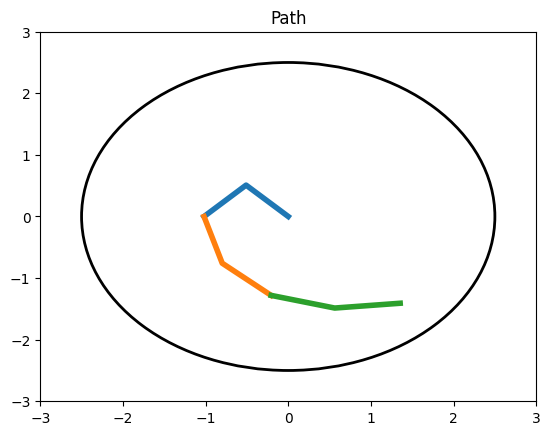

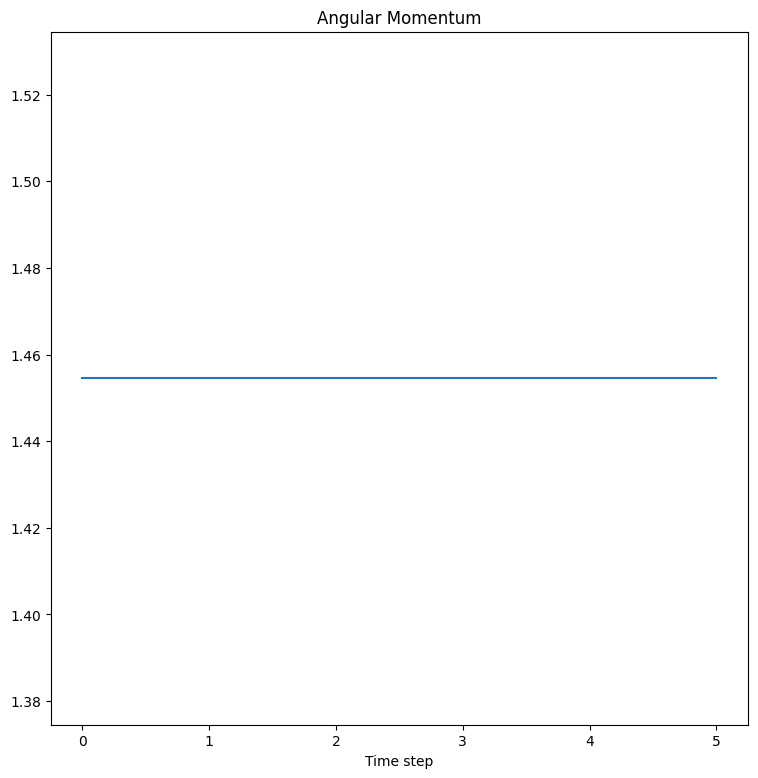

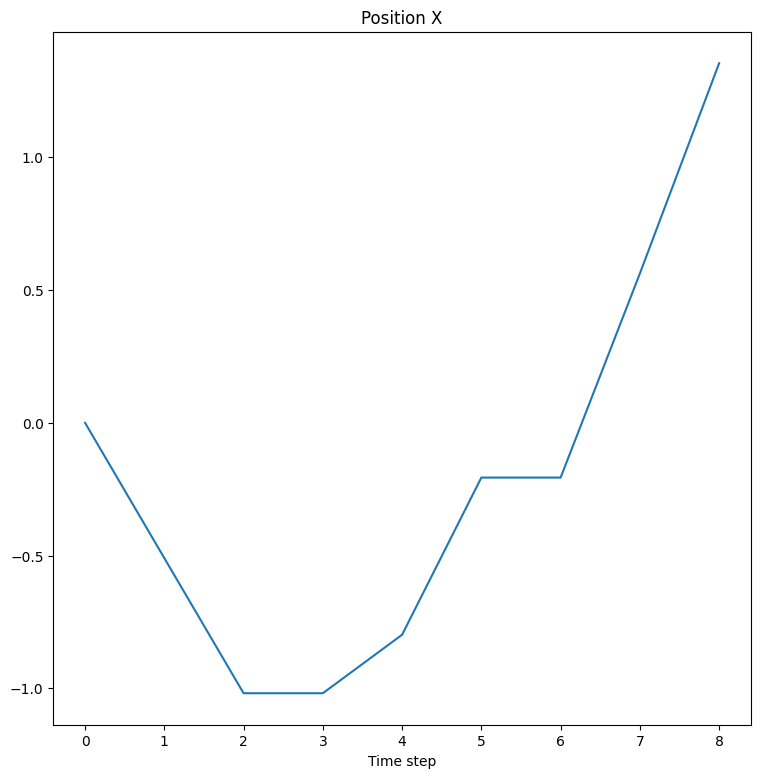

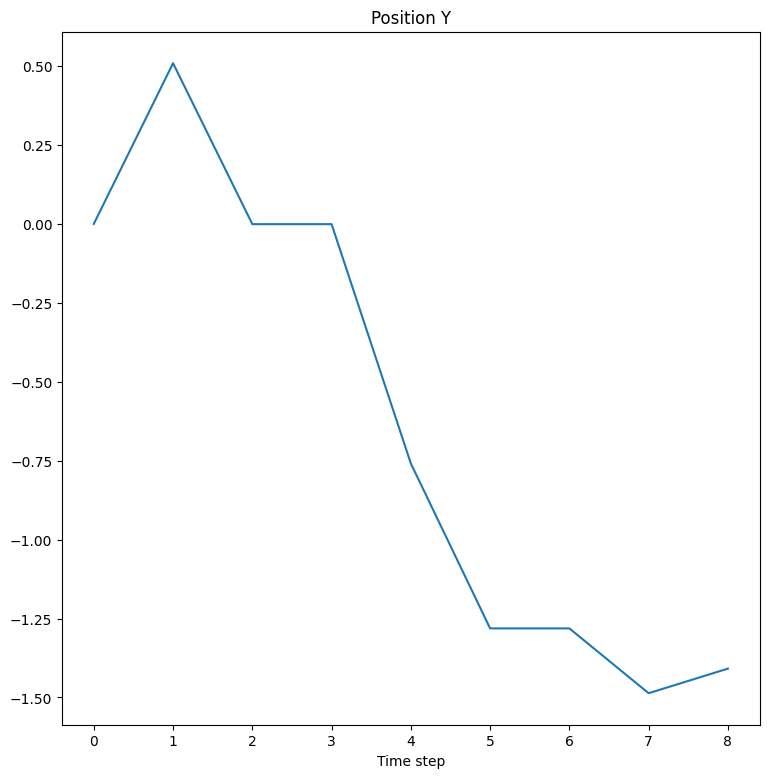

In [639]:
robot = AckermanRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []


#First angle 0.634022719663 @ 0.4 sec

#Straight 0.1 sec

#Second angle 0.329771529972 @ ? sec

# Move to outside of the circle
# robot.theta = 0.634022719663

# Get To outside of circle
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.3, 8, 0)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

# Magic turn in place because ive lost it
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.1, 8, pi)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)



sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(1, 8, 0.5585993153)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")


plot_path_x_y_angular_velocities(path_x, path_y, angular_momentum)


In [634]:
# robot.get_R(8, )